## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
####fixes from internet for ImportError: cannot import name 'triu' from 'scipy.linalg'
##doesn't help
#from numpy import triu

##looks like scipy version 1.13.1 doesn't support "triu" so I guess I'm going to install an older version??
#!pip uninstall scipy verbose
#!pip install scipy==1.12


In [2]:
pip show scipy

Name: scipy
Version: 1.12.0
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2024, SciPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions
are met:

1. Redistributions of source code must retain the above copyright
   notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above
   copyright notice, this list of conditions and the following
   disclaimer in the documentation and/or other materials provided
   with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived
   from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRI

In [3]:
#!pip install contractions
import contractions

In [4]:
import scipy
print(scipy.__version__)

1.12.0


In [5]:
#1. pandas and numpy
import pandas as pd
import numpy as np

#some stuff I needed later
import re

In [6]:
#2. punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
#3. textblob
from textblob import TextBlob

In [8]:
#4. countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
#5. gensim -- this threw an error that I have no idea how to fix. "ImportError: cannot import name 'triu' from 'scipy.linalg'"
# Installing scipy 1.12 fixed that error.
import gensim
from gensim import models

In [10]:
#6. plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
#Others
from wordcloud import WordCloud
import scattertext as st

In [12]:
# #1. pandas and numpy
# import pandas as pd
# import numpy as np

# # punctuation, stop words and English language model
# from string import punctuation
# from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_web_sm
# nlp = en_core_web_sm.load()

# # textblob
# from textblob import TextBlob

# # countvectorizer, tfidfvectorizer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # gensim
# import gensim
# from gensim import models

# # plotting
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

In [13]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [14]:
type(congress_tweets)

pandas.core.frame.DataFrame

In [15]:
##subsetting the data for testing
# subset the first 100 rows
congress_tweets_100 = congress_tweets[:100]

In [16]:
#Going to reclass Angus King and Bernie as dems so there are two categories 
independent_screennames_unique = congress_tweets.loc[congress_tweets['party'] == 'Independent', 'screen_name'].drop_duplicates()
print(independent_screennames_unique)

368301    SenAngusKing
848770      SenSanders
Name: screen_name, dtype: object


In [17]:
unique_parties = congress_tweets['party'].unique()
print(unique_parties)

['Republican' 'Democrat' 'Independent']


In [18]:
congress_tweets['party'] = congress_tweets['party'].replace('Independent', 'Democrat')

In [19]:
unique_parties = congress_tweets['party'].unique()
print(unique_parties)

['Republican' 'Democrat']


In [20]:
##or random set of 100? setting a seed for repro
np.random.seed(10)
ct_samp = congress_tweets.sample(n=100)
ct_samp


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
36257,1.276160e+18,RepDavid,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"
548996,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
652347,1.322270e+18,RepSteveChabot,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
267614,1.103730e+18,SenatorRisch,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911"
344386,1.097350e+18,RepThomasMassie,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756784,1.331630e+18,SenAlexander,2020-11-25T11:18:06-05:00,“More people than ever are visiting emergency ...,Lamar Alexander,Sen,3-Jan-03,7/3/1940,M,TN,Senate,Republican,"1,522,925","870,695","960,709","1,462,330"
144902,1.306270e+18,RepGaramendi,2020-09-16T12:50:37-04:00,RT @CA_Water_News Rep. Garamendi Introduces Le...,John Garamendi,Rep,3-Nov-09,1/24/1945,M,CA,3,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
512391,1.167100e+18,SenatorMenendez,2019-08-29T11:45:52-04:00,RT @LAWGaction We commend @SenatorMenendez and...,Robert Menendez,Sen,17-Jan-06,1/1/1954,M,NJ,Senate,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"
19166,1.166000e+18,RepDavid,2019-08-26T10:37:52-04:00,I have been reading articles discussing robote...,David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"


In [21]:
## function: original code
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]

    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [25]:
##applying function to relevant column in ct_samp
ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
ct_samp['tokens'] # visualize

36257     [Before, adopting, Olivia, spent, great, time,...
548996    [Are, supposed, Trump, seriously, literally, s...
652347    [Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...
267614    [Made, remarks, AmFreeSyria, sharing, concern,...
344386    [jeroneanderson, MontcoLP, LelandShow, realDon...
                                ...                        
756784    [“, More, people, visiting, emergency, rooms, ...
144902    [RT, CAWaterNews, Rep, Garamendi, Introduces, ...
512391    [RT, LAWGaction, We, commend, SenatorMenendez,...
19166     [I, reading, articles, discussing, robotexting...
532780    [Thank, Morris, amp, Warren, Counties, joined,...
Name: tokens, Length: 100, dtype: object

In [23]:
##trying to look at the text to figure out how to pre-process
for text in ct_samp['text']:
    print(text)

Before adopting Olivia, we spent a great amount of time learning about Arizona’s foster care system and the different processes available for welcoming a child. I am pleased to see this Administration take action to support our Child Welfare System and foster youth. https://twitter.com/HHSGov/status/1275852190461165573 QT @HHSGov Learn more from @ACFHHS about how today's Executive Order (EO) strengthens America's child welfare system and aims to improve outcomes for children and families: https://www.acf.hhs.gov/media/press/2020/president-trump-signs-historic-child-welfare-executive-order?utm_source=TWITTER&utm_medium=TWITTER&utm_content=100001368435789&utm_campaign=Engagement&linkId=100000013147644 http://pbs.twimg.com/media/EbS8zkpXYAEOHO0.jpg
Are we supposed to take Trump seriously or literally on this "steel barrier" thing? Somebody call Peter Thiel.
Thank you to Lieutenant Mike Tarr and Fire Chief Ott Huber for the update and for all you do to keep us safe. http://pbs.twimg.com/me

In [24]:
for t in ct_samp['tokens']:
    print(t)

['Before', 'adopting', 'Olivia', 'spent', 'great', 'time', 'learning', 'Arizona', 'foster', 'care', 'system', 'different', 'processes', 'available', 'welcoming', 'child', 'I', 'pleased', 'Administration', 'action', 'support', 'Child', 'Welfare', 'System', 'foster', 'youth', 'QT', 'HHSGov', 'Learn', 'ACFHHS', 'todays', 'Executive', 'Order', 'EO', 'strengthens', 'Americas', 'child', 'welfare', 'system', 'aims', 'improve', 'outcomes', 'children', 'families']
['Are', 'supposed', 'Trump', 'seriously', 'literally', 'steel', 'barrier', 'thing', 'Somebody', 'Peter', 'Thiel']
['Thank', 'Lieutenant', 'Mike', 'Tarr', 'Fire', 'Chief', 'Ott', 'Huber', 'update', 'safe']
['Made', 'remarks', 'AmFreeSyria', 'sharing', 'concern', 'devastation', 'wrought', 'brutal', 'dictator', 'Assad', 'I', 'supported', 'S1', 'authorizes', 'sanctions', 'regime', ' ', 'Russian', 'amp', 'Iranian', 'backers', 'atrocities', 'civilians', 'I', 'urge', 'House', 'colleagues', 'swiftly']
['jeroneanderson', 'MontcoLP', 'LelandSho

#NH: Making edits to preprocessing here: 

Removing punctuation and stop words, removing mentions and hashtags, removing emojis (if possible!), removing http, lowercase. I think also maybe removing numbers, abbreviations, and quotation marks is a good idea. My computer is really slow so I think the more I remove the better off I'll be.  I guess I'll lemmatize for the same reason? 

Not sure what to do about entities. Going to leave them alone for now. 

On removing hashtags and mentions -- mentions I feel sure of, because while they illustrate sentiment and loyalty there's no real way to code which was the mention is going (support or recrimination) and what valence each account shows. Hashtags I'm less sure of -- a lot of time they are just filler (#TBT!) but sometimes they do show sentiment. But also, they are not spaced so I'm not sure spacy will deal with them as words or not? Could just be a huge lemmatization problem. And in general hastags only repeat sentiments already expressed in the body of the text, unless they are there for comedic effect. So I'm leaning towards getting rid of them. I might regret it though. 

In [26]:
##custom dictionary of random words I keep seeing in the random samples
abbreviations = {
    'qt': '', 
    'rt': '',    
    'amp': '',  
    's': '',  
    'n': ''  
}

##preprocessing function. Not sure if it's best practice to shove everything into this function, but it seems to work so I'm going for it.
##decided to lemmatize as well, hoping it'll make things quicker? 
def rem_punc_stop_lem(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)

    #Lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove fragments like 'l, 't, 's, etc.
    text = re.sub(r"'[a-zA-Z]+", "", text)

    # Remove abbreviations
    for abbr, replacement in abbreviations.items():
        text = re.sub(r'\b' + abbr + r'\b', replacement, text)
    
    # Tokenize 
    doc = nlp(text)
    
    # Extract/lemmatize while filtering out mentions (words that start with '@')
    lem_words = [token.lemma_ for token in doc if not token.text.startswith('@')]
    
    # Reconstruct text again without mentions
    text_no_mentions = " ".join(lem_words)

    # Remove punctuation 
    punc_free = "".join([ch for ch in text_no_mentions if ch not in punc])

    # Remove numbers
    punc_free = re.sub(r'\d+', '', punc_free) 

    #Remove emojis
    punc_free = re.sub(r'[^\x00-\x7F]+', '', punc_free) 

    #getting rid of random spaces and newline html stuff 
    punc_free = re.sub(r'\s+', ' ', punc_free)  # replace multiple spaces/newlines/tabs/etc with single space
    punc_free = punc_free.strip()  # remove leading/trailing 
    
    # Tokenize again
    doc = nlp(punc_free)

    # Extract 
    lem_words = [token.lemma_ for token in doc]

    # Remove words that start with 'http' (URLs)
    lem_words = [word for word in lem_words if not word.startswith('http')]

    # Remove stop words
    no_punc = [word for word in lem_words if word not in stop_words]

    return no_punc

In [27]:
##trying to expand results to get a look at what I've got. Not sure why some emojis have made it through...

np.random.seed(12)
ct_samp = congress_tweets.sample(n=100)
ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop(x)) 
for t in ct_samp['tokens']:
    print(t)

['Wishing', 'blessed', 'month', 'observing', 'Ramadan', 'Central', 'Valley', '\n \n', 'During', 'difficult', 'times', 'let', 'remember', 'values', 'faith', 'teaches', 'hope', 'compassion', 'community']
['Thank', 'joined', 'Tom', 'Congress', 'In', 'Your', 'Kitchen', 'meeting', 'afternoon', 'Hunterdon', 'Somerset', 'Counties', 'Participants', 'asked', 'questions', 'topics', 'ranging', 'security', 'elections', 'Equal', 'Rights', 'Amendment']
['Impeachment', 'case', 'laid', 'clearly', 'Trump', 'abused', 'power', 'cheat', 'elections', ' ', 'despite', 'admitting', ' ', 'tried', 'cover', '\n\n', 'The', 'facts', 'overwhelming', '\n\n', 'If', 'witness', 'tell', 'different', 'story', 'GOP', 'senators', 'want', 'hear', '\n\n', 'DefendOurDemocracy']
['From', 'Grand', 'Canyon', 'breathtaking', 'size', 'Yosemite', 'aweinspiring', 'wildlife', 'magnificent', 'coastal', 'scenery', 'Maine', 'AcadiaNPS', 'sites', 'embody', 'Americas', 'limitless', 'natural', 'potential', 'diversity', 'experience', 'promi

In [28]:
np.random.seed(4)
ct_samp = congress_tweets.sample(n=100)
ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
for t in ct_samp['tokens']:
    print(t)

['allow', 'million', 'american', 'household', 'lose', 'income', 'create', 'humanitarian', 'crisis', 'radiate', 'damage', 'economy', 'devastating', 'policy', 'income', 'allow', 'happen', 'aid', 'package', 'care', 'act', 'jobless', 'aid', 'program', 'cut', 'entirely', 'december', 'half', 'receive', 'unemployment', 'benefit', 'million', 'people', 'stand', 'leave', 'income', 'w']
['proud', 'tx', 'mask', 'eteer', 'earn', 'rise', 'star', 'award', 'I', 'love', 'ingenuity', 'write', 'letter', 'support', 'award', 'creativity', 'stopthespread', 'remarkable', 'detail']
['retire', 'nurse', 'state', 'physician', 'line', 'help', 'coronavirus', 'outbreak', 'exactly', 'need', 'healthcare', 'field', 'want', 'help', 'texas', 'respond', 'txlege', 'covid']
['newspaper', 'close', 'rep', 'cicilline', 'introduce', 'journalism', 'competition', 'preservation', 'act', 'democracy', 'strong', 'free', 'open', 'press', 'inform', 'citizen', 'hold', 'public', 'official', 'accountable', 'root', 'corruption']
['consens

In [31]:
np.random.seed(12)
ct_samp = congress_tweets.sample(n=100)
ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
for t in ct_samp['tokens']:
    print(t)

['wish', 'blessed', 'month', 'observe', 'ramadan', 'central', 'valley', 'difficult', 'time', 'let', 'remember', 'value', 'faith', 'teach', 'hope', 'compassion', 'community']
['thank', 'join', 'tom', 'congress', 'kitchen', 'meeting', 'afternoon', 'hunterdon', 'somerset', 'county', 'participant', 'ask', 'question', 'topic', 'range', 'security', 'election', 'equal', 'right', 'amendment']
['impeachment', 'case', 'lie', 'clearly', 'trump', 'abuse', 'power', 'cheat', 'election', 'despite', 'admit', 'try', 'cover', 'fact', 'overwhelming', 'witness', 'tell', 'different', 'story', 'gop', 'senator', 'want', 'hear', 'defendourdemocracy']
['grand', 'canyon', 'breathtaking', 'size', 'yosemite', 'awe', 'inspire', 'wildlife', 'magnificent', 'coastal', 'scenery', 'maine', 'site', 'embody', 'america', 'limitless', 'natural', 'potential', 'diversity', 'experience', 'promise', 'pass', 'world', 'child']
['exactly', 'I', 'introduce', 'health', 'care', 'emergency', 'guarantee', 'act', 'cover', 'health', 'co

In [32]:
# # did lemmatizing do anything? (commenting out since lemmatizing worked and the comparison var is defunct. )
# subset_tokens = ct_samp[['tokens', 'tokens_lem']]
# print(subset_tokens)

In [33]:
###This is what I would do if my computer were faster and I could apply the function to the full data. 

# # ##applying function to full data
# congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop_lem(x))


In [34]:
#how many obs
congress_tweets.shape

(946791, 16)

In [35]:
## keeps timing out. Let's try with a bit more than 100
#500 = 30 seconds
#1000 = 1 minute
#947,000 = 16 hours
np.random.seed(12)
ct_samp = congress_tweets.sample(n=1000)
ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
121376,1.253430e+18,RepTjCox,2020-04-23T17:23:43-04:00,Wishing a blessed month to all observing #Rama...,TJ Cox,Rep,3-Jan-19,7/18/1963,M,CA,21,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[wish, blessed, month, observe, ramadan, centr..."
532544,1.301630e+18,RepMalinowski,2020-09-03T17:07:49-04:00,Thank you to everyone who joined Tom’s Congres...,Tom Malinowski,Rep,3-Jan-19,9/23/1965,M,NJ,7,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568","[thank, join, tom, congress, kitchen, meeting,..."
106318,1.221070e+18,RepBarragan,2020-01-25T09:01:51-05:00,#Impeachment case has been laid out clearly. T...,Nanette Barragán,Rep,3-Jan-17,9/15/1976,F,CA,44,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[impeachment, case, lie, clearly, trump, abuse..."
368459,1.093910e+18,SenAngusKing,2019-02-08T11:30:42-05:00,From the Grand Canyon’s breathtaking size to Y...,Angus King,Sen,3-Jan-13,3/31/1944,M,ME,Senate,Democrat,"335,593","357,735","401,306","292,276","[grand, canyon, breathtaking, size, yosemite, ..."
853636,1.262360e+18,SenSanders,2020-05-18T08:42:19-04:00,RT @RepJayapal This is exactly why @SenSanders...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,VT,Senate,Democrat,"95,369","178,573","199,239","92,698","[exactly, I, introduce, health, care, emergenc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868293,1.180100e+18,GerryConnolly,2019-10-04T08:48:46-04:00,Some of my GOP colleagues tried to suggest to ...,Gerry Connolly,Rep,3-Jan-09,3/30/1950,M,VA,11,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[gop, colleague, try, suggest, medium, explosi..."
115963,1.242850e+18,RepScottPeters,2020-03-25T12:41:17-04:00,"#ICYMI, #TaxDay has been moved: the due date f...",Scott Peters,Rep,3-Jan-13,6/17/1958,M,CA,52,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[icymi, taxday, date, federal, income, tax, re..."
541732,1.156540e+18,RepDebHaaland,2019-07-31T08:25:30-04:00,Indigenous communities across the globe are fa...,Deb Haaland,Rep,3-Jan-19,12/2/1960,F,NM,1,Democrat,"319,667","385,234","415,335","335,788","[indigenous, community, globe, face, violence,..."
431415,1.279190e+18,RepDebDingell,2020-07-03T19:23:38-04:00,It’s going to take all of us to beat this viru...,Debbie Dingell,Rep,3-Jan-15,11/23/1953,F,MI,12,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256","[beat, virus, holiday, weekend, let, sure, sma..."


## Kasey - my computer is too slow. I'm going to stick with a group of a thousand. Thanks for your flexibility!

In [36]:
#taking a look at the tokens in this group of 1,000; looks ok. 
for t in ct_samp['tokens']:
    print(t)

['wish', 'blessed', 'month', 'observe', 'ramadan', 'central', 'valley', 'difficult', 'time', 'let', 'remember', 'value', 'faith', 'teach', 'hope', 'compassion', 'community']
['thank', 'join', 'tom', 'congress', 'kitchen', 'meeting', 'afternoon', 'hunterdon', 'somerset', 'county', 'participant', 'ask', 'question', 'topic', 'range', 'security', 'election', 'equal', 'right', 'amendment']
['impeachment', 'case', 'lie', 'clearly', 'trump', 'abuse', 'power', 'cheat', 'election', 'despite', 'admit', 'try', 'cover', 'fact', 'overwhelming', 'witness', 'tell', 'different', 'story', 'gop', 'senator', 'want', 'hear', 'defendourdemocracy']
['grand', 'canyon', 'breathtaking', 'size', 'yosemite', 'awe', 'inspire', 'wildlife', 'magnificent', 'coastal', 'scenery', 'maine', 'site', 'embody', 'america', 'limitless', 'natural', 'potential', 'diversity', 'experience', 'promise', 'pass', 'world', 'child']
['exactly', 'I', 'introduce', 'health', 'care', 'emergency', 'guarantee', 'act', 'cover', 'health', 'co

In [37]:
### The first pass took a really long time, so I asked chatgpt to make the code more efficient. This was the result.  
### commenting out because this didn't help at all

# ##Load spaCy model once (for efficiency)
# nlp = spacy.load('en_core_web_sm', disable=["ner", "parser"])  # Disable unnecessary components

# # Precompile regex patterns for efficiency
# apostrophe_fragments = re.compile(r"'[a-zA-Z]+")  # Match contractions like 's, 't, etc.
# non_ascii_chars = re.compile(r"[^\x00-\x7F]+")  # Match emojis and non-ASCII characters
# extra_spaces = re.compile(r"\s+")  # Match multiple spaces

# # Custom dictionary of words to remove
# abbreviations = {'qt', 'rt', 'amp', 's', 'n'}

# def rem_punc_stop_lem_efficient(text):
#     """Preprocess text by lowercasing, removing contractions, lemmatizing, 
#     and filtering out stop words, punctuation, and unwanted elements."""
    
#     # Lowercase text
#     text = text.lower()

#     # Expand contractions (e.g., "he'd" -> "he would")
#     text = contractions.fix(text)

#     # Remove apostrophe fragments (e.g., 's, 't, etc.)
#     text = apostrophe_fragments.sub("", text)

#     # Tokenize and process text in **one pass**
#     doc = nlp(text)

#     # Extract & lemmatize words while filtering
#     lem_words = [
#         token.lemma_ for token in doc 
#         if not token.is_stop  # Remove stop words
#         and not token.is_punct  # Remove punctuation
#         and not token.text.startswith('@')  # Remove mentions (@user)
#         and not token.text.startswith('http')  # Remove URLs
#         and token.text not in abbreviations  # Remove custom words
#         and not token.is_digit  # Remove numbers
#     ]

#     # Remove non-ASCII characters (emojis)
#     punc_free = non_ascii_chars.sub("", " ".join(lem_words))

#     # Replace multiple spaces and strip leading/trailing whitespace
#     cleaned_text = extra_spaces.sub(" ", punc_free).strip()

#     return cleaned_text.split()  # Return as a list of tokens


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: word cloud

In [49]:
np.random.seed(12)
ct_samp_100 = congress_tweets.sample(n=100)
ct_samp_100['tokens'] = ct_samp_100['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp_100

np.random.seed(12)
ct_samp_1000 = congress_tweets.sample(n=1000)
ct_samp_1000['tokens'] = ct_samp_1000['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp_1000

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
121376,1.253430e+18,RepTjCox,2020-04-23T17:23:43-04:00,Wishing a blessed month to all observing #Rama...,TJ Cox,Rep,3-Jan-19,7/18/1963,M,CA,21,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[wish, blessed, month, observe, ramadan, centr..."
532544,1.301630e+18,RepMalinowski,2020-09-03T17:07:49-04:00,Thank you to everyone who joined Tom’s Congres...,Tom Malinowski,Rep,3-Jan-19,9/23/1965,M,NJ,7,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568","[thank, join, tom, congress, kitchen, meeting,..."
106318,1.221070e+18,RepBarragan,2020-01-25T09:01:51-05:00,#Impeachment case has been laid out clearly. T...,Nanette Barragán,Rep,3-Jan-17,9/15/1976,F,CA,44,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[impeachment, case, lie, clearly, trump, abuse..."
368459,1.093910e+18,SenAngusKing,2019-02-08T11:30:42-05:00,From the Grand Canyon’s breathtaking size to Y...,Angus King,Sen,3-Jan-13,3/31/1944,M,ME,Senate,Democrat,"335,593","357,735","401,306","292,276","[grand, canyon, breathtaking, size, yosemite, ..."
853636,1.262360e+18,SenSanders,2020-05-18T08:42:19-04:00,RT @RepJayapal This is exactly why @SenSanders...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,VT,Senate,Democrat,"95,369","178,573","199,239","92,698","[exactly, I, introduce, health, care, emergenc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868293,1.180100e+18,GerryConnolly,2019-10-04T08:48:46-04:00,Some of my GOP colleagues tried to suggest to ...,Gerry Connolly,Rep,3-Jan-09,3/30/1950,M,VA,11,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[gop, colleague, try, suggest, medium, explosi..."
115963,1.242850e+18,RepScottPeters,2020-03-25T12:41:17-04:00,"#ICYMI, #TaxDay has been moved: the due date f...",Scott Peters,Rep,3-Jan-13,6/17/1958,M,CA,52,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[icymi, taxday, date, federal, income, tax, re..."
541732,1.156540e+18,RepDebHaaland,2019-07-31T08:25:30-04:00,Indigenous communities across the globe are fa...,Deb Haaland,Rep,3-Jan-19,12/2/1960,F,NM,1,Democrat,"319,667","385,234","415,335","335,788","[indigenous, community, globe, face, violence,..."
431415,1.279190e+18,RepDebDingell,2020-07-03T19:23:38-04:00,It’s going to take all of us to beat this viru...,Debbie Dingell,Rep,3-Jan-15,11/23/1953,F,MI,12,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256","[beat, virus, holiday, weekend, let, sure, sma..."


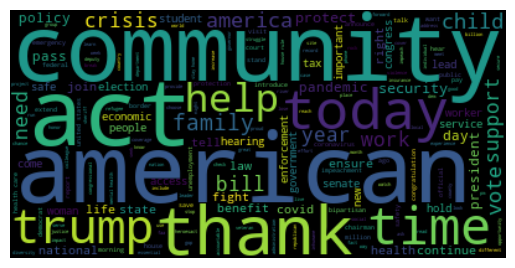

In [45]:
## Since I'm computationally challenged, I'm going to use the sample of 100 for this
# converting tokens to a string
text = ' '.join(ct_samp_100['tokens'].map(lambda text: ' '.join(text)))

# WordCloud viz
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

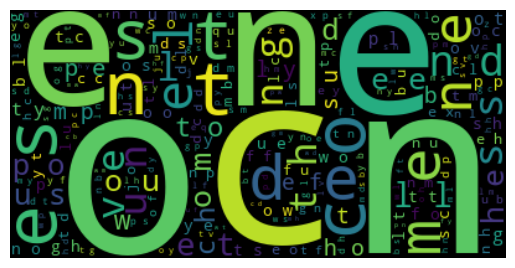

In [57]:
## Just going to see what happens with 1000
# converting tokens to a string
text = ' '.join(ct_samp_1000['tokens'].map(lambda text: ' '.join(text)))

# WordCloud viz
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2: Scattertext

In [51]:
# sample of 100
##cleaning party column
#NAs
ct_samp_100 = ct_samp_100.dropna(subset=['party'])
#categorical
ct_samp_100['party'] = ct_samp_100['party'].astype('category')
print(ct_samp_100['party'].isna().sum())  # Ensure there are no missing values

0


In [53]:
# create measure with sample of 100
#make a string to avoid value error
ct_samp_100['tokens'] = ct_samp_100['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


corpus = st.CorpusFromPandas(ct_samp_100,              # specify data 
                             category_col = 'party',   # specify the explanatory variable (how it'll be split)  
                             text_col = 'tokens',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

# create html document
html = st.produce_scattertext_explorer(corpus,  
                                       category='Republican',  # Category 1
                                       category_name='Republican',  # label category 1
                                       not_category_name='Democrat',  # Category 2
                                       width_in_pixels=1000,  
                                       minimum_term_frequency=5,  # Only include terms that appear at least 5 times?
                                       metadata=ct_samp_100['tweet_id'])  # Use "tweet_id" as id 

In [54]:
# Save the HTML content to a file sample of 100
with open("Tweets_Sentiment.html", 'w', encoding='utf-8') as f:
    f.write(html)

# Automatically open the HTML file in the default browser
import webbrowser
webbrowser.open("Tweets_Sentiment.html")


True

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [ ]:
...

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [ ]:
...

### Engineered Text Features

In [ ]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
...

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...